In [1]:
import numpy as np
import pandas as pd
import os, sys, math
import pickle
import matplotlib.pyplot as plt
from IPython.display import display

Load our model for demand estimates based on covariates

In [2]:
filename = 'xgbclassifier_v1.pkl'
trained_model = pickle.load(open(filename, 'rb'))

In [3]:
df = pd.read_csv('../../data/train_prices_decisions.csv')

Determine what prices to check for when finding optimal revenue price.

In [4]:
min_p0 = df.price_item_0.min()
max_p0 = df.price_item_0.max()
min_p1 = df.price_item_1.min()
max_p1 = df.price_item_1.max()

In [5]:
min_b_p0 = df[df.item_bought == 0].price_item_0.min()
max_b_p0 = df[df.item_bought == 0].price_item_0.max()
min_b_p1 = df[df.item_bought == 1].price_item_1.min()
max_b_p1 = df[df.item_bought == 1].price_item_1.max()

In [6]:
display(min_p0, max_p0, min_p1, max_p1)

3.301688718503524

373.26491426696936

0.01

548.9457693140431

In [7]:
display(min_b_p0, max_b_p0, min_b_p1, max_b_p1)

3.301688718503524

90.0983819412393

0.01

133.45022372058264

In [8]:
avg_b_p0 = df[df.item_bought == 0].price_item_0.mean()
med_b_p0 = df[df.item_bought == 0].price_item_0.median()
avg_b_p1 = df[df.item_bought == 1].price_item_1.mean()
med_b_p1 = df[df.item_bought == 1].price_item_1.median()

In [9]:
display(avg_b_p0, med_b_p0, avg_b_p1, med_b_p1)

29.786000054719874

35.07431361873993

39.70018995436332

41.01058623190984

The prices that were offered vs. what was actually bought differs quite a lot. We may or may not want to include extremely high prices to determine what to charge, but if it does not impact runtime much then shouldn't be a huge issue.

<Axes: >

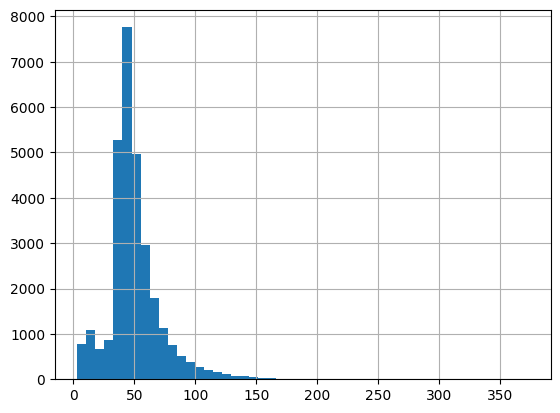

In [14]:
df.price_item_0.hist(bins=50)

<Axes: >

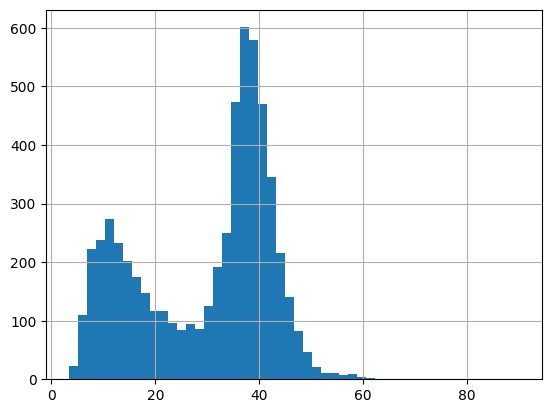

In [11]:
df[df.item_bought == 0].price_item_0.hist(bins=50)

<Axes: >

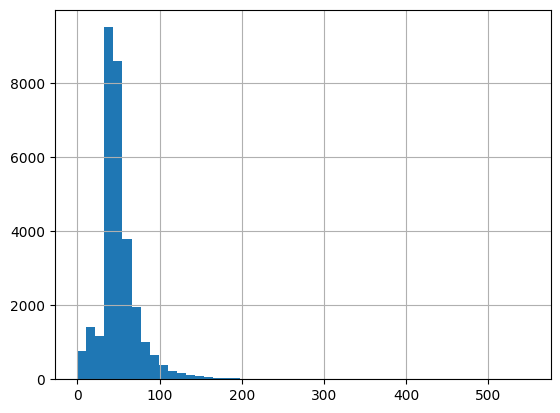

In [13]:
df.price_item_1.hist(bins=50)

<Axes: >

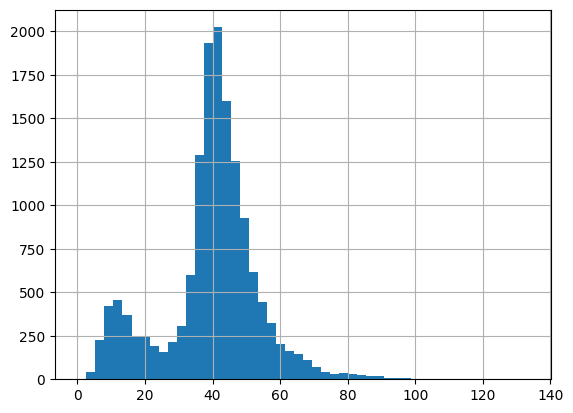

In [15]:
df[df.item_bought == 1].price_item_1.hist(bins=50)

Notice the y-axis, as there are a large proportion of people who do not buy, making the bought hists much lower in count frequency. It also appears that item 1 is bought more frequently

In [45]:
p0_to_predict_all = np.linspace(min_p0, max_p0, 500)
p1_to_predict_all = np.linspace(min_p1, max_p1, 750)

In [47]:
p0_to_predict_bought = np.linspace(min_p0, max_b_p0, 150)
p1_to_predict_bought = np.linspace(min_p1, max_b_p1, 200)

Make it so that we check more prices that were bought at and less from when no one bought to make faster

In [51]:
p0_to_predict_comb = np.concatenate([p0_to_predict_bought, np.linspace(max_b_p0+0.1, max_p0/3, 50), np.linspace(max_p0/3+0.1, max_p0, 50)])
p1_to_predict_comb = np.concatenate([p1_to_predict_bought, np.linspace(max_b_p1+0.1, max_p1/3, 75), np.linspace(max_p0/3+0.1, max_p1, 75)])

This is the basic approach with for loops and everything, but not optimized at all

In [57]:
# TOO SLOW
def get_demand_at_prices(covs, prices0, prices1):
    # p0, p1, 2 (prob buy 0 or 1) 
    demand_at_p = np.zeros((len(prices0), len(prices1), 2))
    for i, p0 in enumerate(prices0):
        for j, p1 in enumerate(prices1):
            X = [covs + [p0, p1]]
            demand_at_p[i, j, :] = trained_model.predict_proba(X)[0][0:-1]
    return demand_at_p

Utilizing some numpy functions here to make faster and batch do the predictions. Although I am not confident that the reshape maintains the indexing such that i in demand corresponds to price0[i]

In [73]:
# MUCH FASTER
def get_demand_at_prices_vectorized_v1(covs, prices0, prices1, trained_model):
    # Create price combinations
    p0_grid, p1_grid = np.meshgrid(prices0, prices1)
    price_combinations = np.column_stack([p0_grid.ravel(), p1_grid.ravel()])

    # Add covariates to each price combination
    covs_repeated = np.repeat([covs], len(price_combinations), axis=0)
    X = np.hstack([covs_repeated, price_combinations])

    # Predict demand for all combinations at once
    demand_predictions = trained_model.predict_proba(X)[:, 0:-1]

    # Reshape the predictions
    demand_at_p = demand_predictions.reshape(len(prices0), len(prices1), 2)
    return demand_at_p

In [74]:
probs = get_demand_at_prices_vectorized_v1([2, 5, 3], p0_to_predict_comb, p1_to_predict_comb, trained_model)
display(probs)

array([[[1.8005075e-01, 8.1962335e-01],
        [1.8005075e-01, 8.1962335e-01],
        [1.8005075e-01, 8.1962335e-01],
        ...,
        [1.5363830e-09, 9.9972135e-01],
        [1.5763372e-09, 9.9972135e-01],
        [1.6073478e-09, 9.9972135e-01]],

       [[1.6073478e-09, 9.9972135e-01],
        [1.6073478e-09, 9.9972135e-01],
        [1.6073478e-09, 9.9972135e-01],
        ...,
        [2.0215472e-09, 9.9972802e-01],
        [2.0215472e-09, 9.9972802e-01],
        [2.0215472e-09, 9.9972802e-01]],

       [[2.0215472e-09, 9.9972802e-01],
        [1.7568521e-09, 9.9976367e-01],
        [1.7568521e-09, 9.9976367e-01],
        ...,
        [8.1838906e-04, 9.9909031e-01],
        [5.3205219e-04, 9.9938285e-01],
        [4.5833594e-04, 9.9945658e-01]],

       ...,

       [[1.7229994e-09, 5.3931304e-10],
        [1.7229994e-09, 5.3931304e-10],
        [1.7229994e-09, 5.3931304e-10],
        ...,
        [9.9964523e-01, 3.0066813e-09],
        [9.9956340e-01, 3.7001795e-09],
        [

Do price combination beforehand such that we can directly know prices and demand for revenue maximization

In [63]:
p0_grid, p1_grid = np.meshgrid(p0_to_predict_comb, p1_to_predict_comb)
price_combinations = np.column_stack([p0_grid.ravel(), p1_grid.ravel()])

In [64]:
# MUCH FASTER
def get_demand_at_prices_vectorized(covs, price_combinations, trained_model):
    # Add covariates to each price combination
    covs_repeated = np.repeat([covs], len(price_combinations), axis=0)
    X = np.hstack([covs_repeated, price_combinations])

    # Predict demand for all combinations at once
    return trained_model.predict_proba(X)[:, 0:-1]

In [67]:
demand = get_demand_at_prices_vectorized([5, 6, 7], price_combinations, trained_model)
demand

array([[7.9248959e-01, 2.0750627e-01],
       [7.9248959e-01, 2.0750627e-01],
       [7.9248959e-01, 2.0750627e-01],
       ...,
       [7.2036791e-08, 5.2220814e-09],
       [7.2036791e-08, 5.2220814e-09],
       [7.2036791e-08, 5.2220814e-09]], dtype=float32)

For each demand, price pair: calculate revenue and store the maxmimum

In [80]:
def get_revenue_maximizing_prices_and_revenue(demand, price_combinations):
    max_revenue = 0
    max_prices = (0, 0)

    for price_pair, demand in zip(price_combinations, demand):
        p0, p1 = price_pair
        demand0, demand1 = demand

        revenue = p0 * demand0 + p1 * demand1

        if revenue > max_revenue:
            max_revenue = revenue
            max_prices = (p0, p1)

    return max_prices, max_revenue

In [81]:
max_p, max_r = get_revenue_maximizing_prices_and_revenue(demand, price_combinations)

In [82]:
display(max_p, max_r)

(39.41843354944056, 53.654311043450306)

38.39370050902165